# Making static maps with GeoPandas and Matplotlib




Types of plots and their arguments: (**highly recommended**)  
https://residentmario.github.io/geoplot/api_reference.html

In [18]:
import warnings
warnings.simplefilter('ignore')

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd

'0.3.0'

## 1. Load data

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Aside about **locating background map data**:

When you start visualizing geosptial data, all of a sudden you have to find appropriate *background* datasets to include in your maps: country borders, states, counties, etc. 

[Natural Earth](https://www.naturalearthdata.com) is a nice resource for this. So is the U.S. Census [TIGER](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) data. That stands for Topologically Integrated Geographic Encoding and Referencing, obviously.

In [4]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


## 2. Quick-and-easy plot

Full API for `geopandas.GeoDataFrame.plot()`: https://geopandas.org/reference.html#geopandas.GeoDataFrame.plot

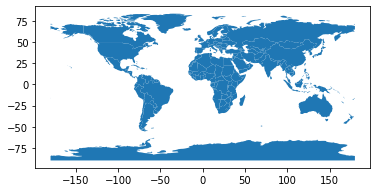

In [12]:
world.plot()

plt.show()  # invoking Matplotlib/PyPlot, 

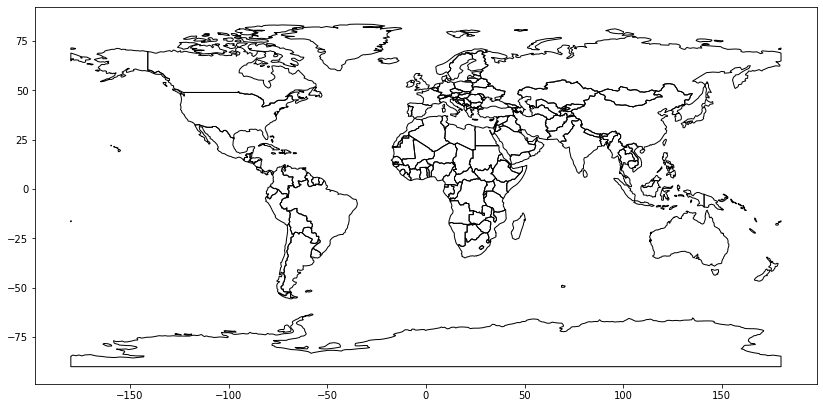

In [15]:
world.plot(color='none', edgecolor='black', linewidth=1, figsize=(14,10))

plt.show()

In [42]:
world.crs

{'init': 'epsg:4326'}

https://epsg.io/4326 = WGS84 lat/lon

When you call `geopandas.GeoDataFrame.plot()`, it plots the coordinate values directly on an x-y axis.

Incidentally, "treating latitude and longitude as x-y coorindates" has a name: it's called a plate carée or equirectangular projection: https://en.wikipedia.org/wiki/Equirectangular_projection

We *could* change the projection by reprojecting the coordinate values in the GeoDataFrame, but we're not going to do that because there are ways to apply projections on the fly when you're making a map.

## 3. Using GeoPlot

This aims to be like Seaborn but for maps (but is not quite as fancy)

`%%capture` suppresses output from the cell, just to keep the notebook tidy.

In [30]:
%%capture
!pip install geoplot;

In [31]:
import geoplot

Types of plots and their arguments: https://residentmario.github.io/geoplot/api_reference.html

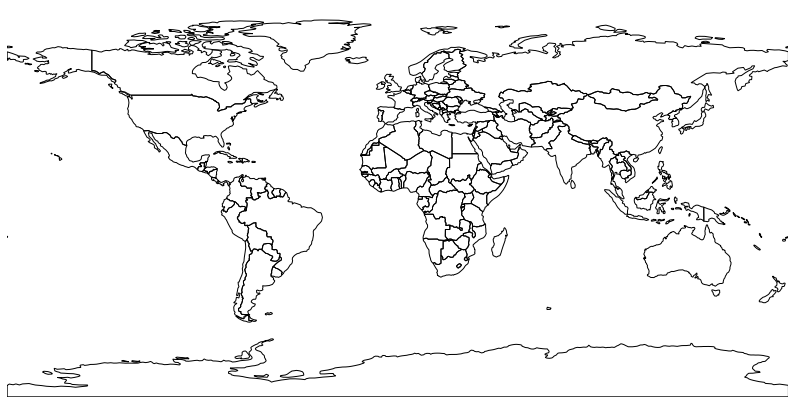

In [39]:
geoplot.polyplot(world, figsize=(14,10))
plt.show()

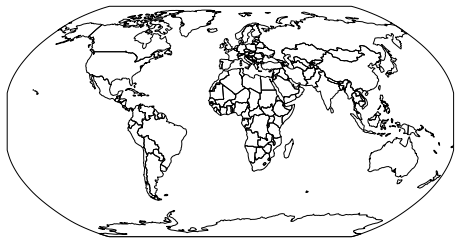

In [41]:
# Here, we can change the projection by passing an argument

ax = geoplot.polyplot(world, projection=geoplot.crs.Robinson())
ax.outline_patch.set_visible(True)  # show map outline
plt.show()

### Exercise

1. Make a plot of a single continent (hint: try filtering the rows in the GeoDataFrame)
  

2. Using the whole world, try setting the GeoPlot projection to `Orthographic()`

## 4. Multiple data layers

We'll switch back to the Bay Area here.

See `spatial-data.ipynb` for more about this data (and to download it)

In [48]:
storefronts = gpd.read_file('all56_nACSxMSA__41860.0.geojson')

In [49]:
tracts = gpd.read_file('zip://tl_2010_06_tract10.zip')

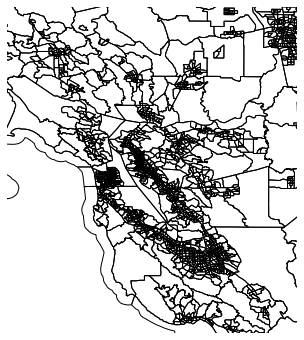

In [52]:
geoplot.polyplot(tracts, extent=(-123,36.9,-121.4,38.7))